# House Prices Prediction

In this project, I aim to predict the sale price of houses based on their characteristics (size, year built, quality, location, etc.).
I use the Kaggle House Prices dataset, which is a well-known benchmark for supervised regression tasks.

My goal is to build and evaluate regression models to estimate the SalePrice.
I start with a baseline linear model and then compare it with more advanced methods such as Random Forests and Gradient Boosting (XGBoost).

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing & pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Evaluation metrics
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    r2_score
)

def evaluate_regression(y_true, y_pred, model_name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    medae = median_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    print(f"----- {model_name} -----")
    print(f"RMSE : {rmse:.4f}")
    print(f"MAE  : {mae:.4f}")
    print(f"MedAE: {medae:.4f}")
    print(f"MAPE : {mape:.2f}%")
    print(f"R²   : {r2:.4f}")
    
    return {"Model": model_name, "RMSE": rmse, "MAE": mae, "MedAE": medae, "MAPE": mape, "R2": r2}


### Data loading & Inspection

In [10]:
df_train = pd.read_csv("../data/train.csv")
df_test = pd.read_csv("../data/test.csv")

print(f"Shape of the train test :{df_train.shape}")
print(f"Shape of the test test :{df_test.shape}")
print(df_train.info())
print(f'Total of Null elements in the train set : {df_train.isna().sum().sum()}')
print(f'Total of Null elements in the test set : {df_test.isna().sum().sum()}')

print(df_train.head())

Shape of the train test :(1460, 81)
Shape of the test test :(1459, 80)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-n

---

### Initial Data Observations  

From the first inspection of the dataset, a few important points emerge:  

- The training set contains **1460 rows and 81 columns**, while the test set has **1459 rows and 80 columns** (no `SalePrice` in the test set).  
- The dataset is a mix of **numeric** and **categorical** variables, meaning preprocessing will need to handle both types separately.  
- There are **7,829 missing values** across several features. Some columns (e.g., `Alley`, `PoolQC`, `Fence`, `MiscFeature`) contain mostly missing data and will be **dropped** from the analysis.  
- The target variable is **`SalePrice`**, which will be the focus of our regression models. Its distribution will need to be checked during EDA to see if a transformation is required.  

These observations already highlight that **data cleaning, imputation, and feature preprocessing** will be critical steps before building any predictive model.  

---

### Exploratory Data Analysis (EDA)

In this section, I perform an initial exploration of the dataset to better understand its structure, identify potential data quality issues, and examine relationships between key features and the target variable `SalePrice`.

The main goals are:
- Check the distribution and skewness of the target variable.
- Identify features with missing values.
- Visualize the most influential variables.

I start by exploring the target variable `SalePrice` to understand its distribution and skewness.  
Then, I check for missing values across the dataset to identify columns that require special treatment before modeling.

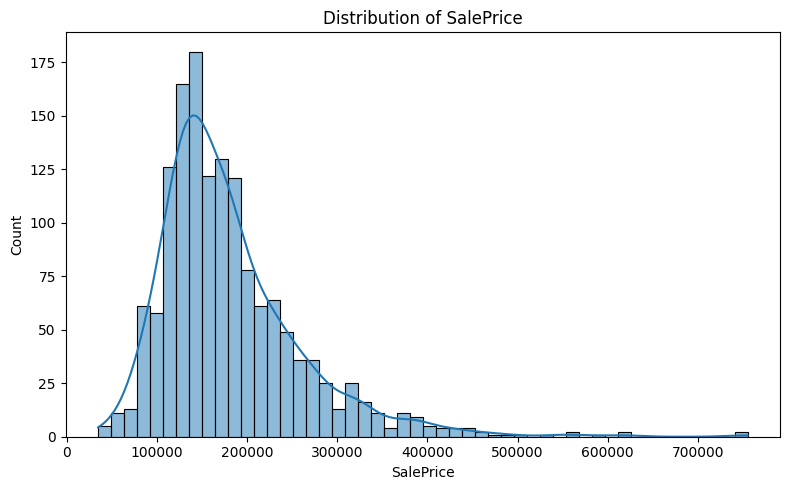

Skewness: 1.88
Kurtosis: 6.54


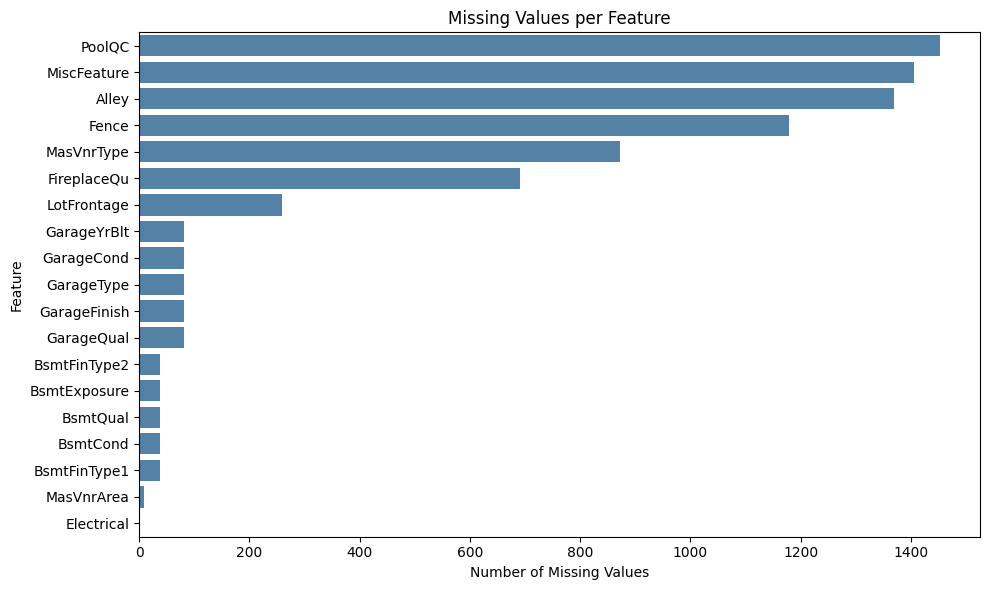

Top 10 features with missing values:
PoolQC         1453
MiscFeature    1406
Alley          1369
Fence          1179
MasVnrType      872
FireplaceQu     690
LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
dtype: int64


In [7]:
# Target variable distribution (SalePrice)
plt.figure(figsize=(8,5))
sns.histplot(df_train["SalePrice"], bins=50, kde=True)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../images/saleprice_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Skewness: {df_train['SalePrice'].skew():.2f}")
print(f"Kurtosis: {df_train['SalePrice'].kurt():.2f}")

# Missing values
missing = df_train.isna().sum().sort_values(ascending=False)
missing = missing[missing > 0]

plt.figure(figsize=(10,6))
sns.barplot(x=missing.values, y=missing.index, color="steelblue")
plt.title("Missing Values per Feature")
plt.xlabel("Number of Missing Values")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("../images/missing_values.png", dpi=300, bbox_inches="tight")
plt.show()

print("Top 10 features with missing values:")
print(missing.head(10))

- The target variable `SalePrice` is right-skewed (Skewness = 1.88, Kurtosis = 6.54).  
  → A log transformation will be applied to make it more normally distributed.  
- Some features (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) contain over 80% missing values and will be dropped.  
- Other features with moderate missingness will be imputed (e.g., median for numerical values, mode or `"None"` for categorical).


---

#### Relationships Between Features and SalePrice

I now explore how key features relate to the target variable `SalePrice`.  
This helps identify which variables are most predictive and whether the relationships are linear or not.

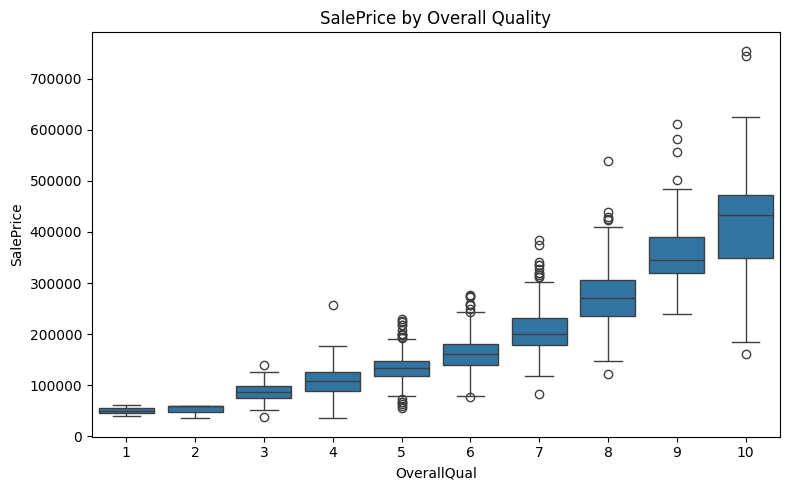

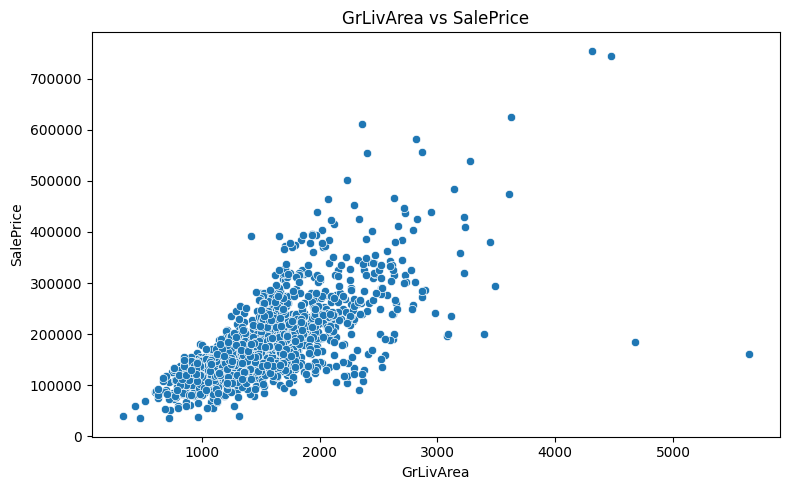

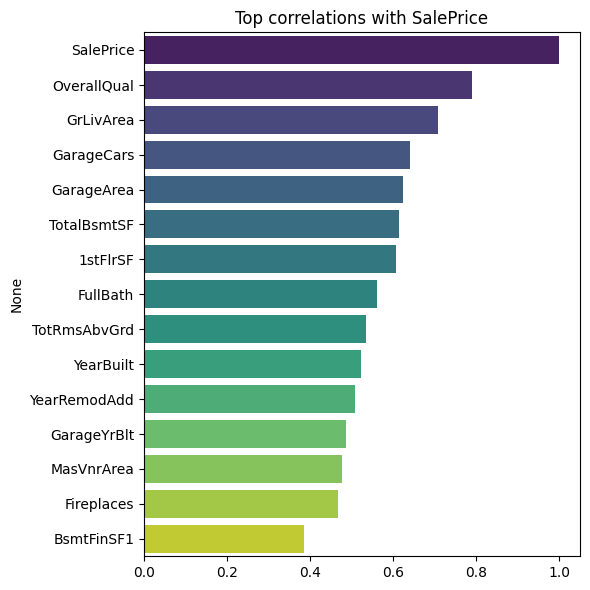

In [8]:
# OverallQual vs SalePrice
plt.figure(figsize=(8,5))
sns.boxplot(x="OverallQual", y="SalePrice", data=df_train)
plt.title("SalePrice by Overall Quality")
plt.tight_layout()
plt.savefig("../images/saleprice_overallqual.png", dpi=300, bbox_inches="tight")
plt.show()

# GrLivArea vs SalePrice
plt.figure(figsize=(8,5))
sns.scatterplot(x="GrLivArea", y="SalePrice", data=df_train)
plt.title("GrLivArea vs SalePrice")
plt.tight_layout()
plt.savefig("../images/saleprice_grlivarea.png", dpi=300, bbox_inches="tight")
plt.show()

# Correlation analysis
corr = df_train.corr(numeric_only=True)
top_corr = corr["SalePrice"].sort_values(ascending=False).head(15)

plt.figure(figsize=(6,6))
sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, palette="viridis", legend=False)
plt.title("Top correlations with SalePrice")
plt.tight_layout()
plt.savefig("../images/top_correlations.png", dpi=300, bbox_inches="tight")
plt.show()

The target variable `SalePrice` shows a strong skewness (1.88).  
To make the distribution more normal, I apply a log transformation using `np.log1p()`.  
This transformation helps models to capture the underlying relationships more effectively.

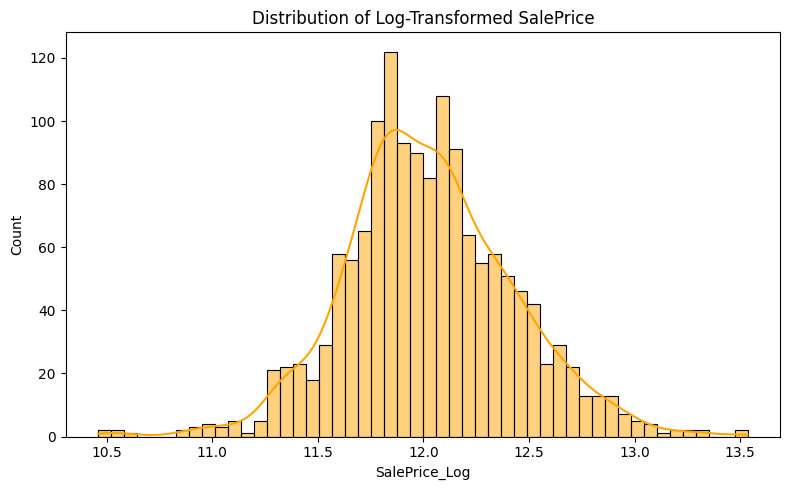

Original SalePrice mean: 180921.20
Transformed SalePrice mean: 12.02


In [15]:
df_train["SalePrice_Log"] = np.log1p(df_train["SalePrice"])

plt.figure(figsize=(8,5))
sns.histplot(df_train["SalePrice_Log"], bins=50, kde=True, color="orange")
plt.title("Distribution of Log-Transformed SalePrice")
plt.xlabel("SalePrice_Log")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("../images/saleprice_log_distribution.png", dpi=300, bbox_inches="tight")
plt.show()

print(f"Original SalePrice mean: {df_train['SalePrice'].mean():.2f}")
print(f"Transformed SalePrice mean: {df_train['SalePrice_Log'].mean():.2f}")

---
### EDA observations

From this exploratory analysis, several key insights emerge:
- `SalePrice` is highly right-skewed so log transformation is justified.  
- A few features (`PoolQC`, `MiscFeature`, `Alley`, `Fence`) have too many missing values and will be dropped.  
- The most correlated features with `SalePrice` include `OverallQual`, `GrLivArea`, `GarageCars`, and `TotalBsmtSF`.  
- Some outliers are visible in `GrLivArea` and will be handled before modeling.  

These insights will directly guide the data preprocessing and feature engineering steps.

---

### Pre-Processing
We can remove the Time column because it is just the time passed since the first transaction, it have no impact on the result.

In [3]:
X = df.drop(columns=["Class", 'Time'])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=RANDOM_STATE)

In [4]:
features_to_scale = ["Amount"]
features_passthrough = []
for i in X.columns:
    if i not in features_to_scale:
        features_passthrough.append(i)

preprocess = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), features_to_scale),
        ('passthrough', 'passthrough', features_passthrough)
    ]
)

---

## Logistic Regression

In [11]:
pipeline_LR = make_pipeline(
    preprocess,
    LogisticRegression(class_weight="balanced", random_state=RANDOM_STATE)
)

param_grid_LR = {
    "logisticregression__penalty": ["l1", "l2"],
    "logisticregression__C": [0.01, 0.1, 1, 10, 100],
    "logisticregression__solver": ["liblinear", "saga"]
}
grid_LR = GridSearchCV(
    estimator=pipeline_LR,
    param_grid=param_grid_LR,
    scoring="roc_auc",
    n_jobs=-1
)

grid_LR.fit(X_train, y_train)
print(f'Best params :\n{grid_LR.best_params_}')

best_LR = grid_LR.best_estimator_
y_pred_LR = best_LR.predict(X_test)
y_proba = best_LR.predict_proba(X_test)[:, 1]

Best params :
{'logisticregression__C': 0.01, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'saga'}


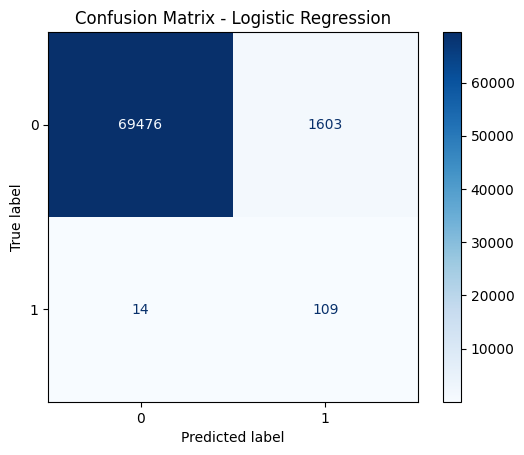

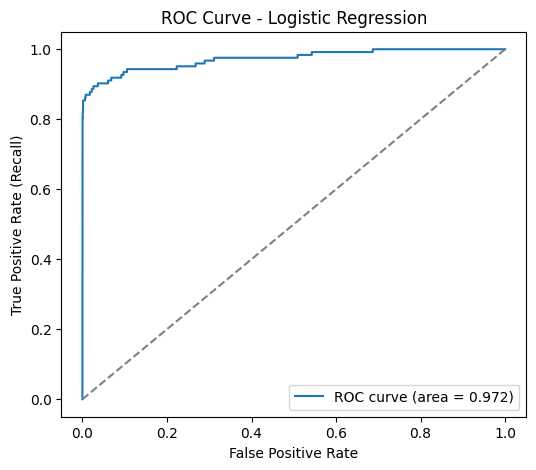

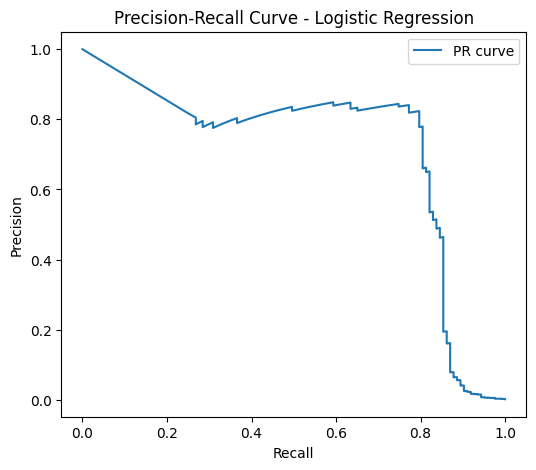

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.savefig("../images/confusion_matrix_logreg.png", dpi=300, bbox_inches="tight")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.savefig("../images/roc_curve_logreg.png", dpi=300, bbox_inches="tight")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(recall, precision, label="PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.legend()
plt.savefig("../images/pr_curve_logreg.png", dpi=300, bbox_inches="tight")
plt.show()

- The best model was found with **L1 penalty** and **C=0.01**.  
- It achieves a **ROC-AUC of 0.97**, which is a very good overall performance.  
- The model has a **high recall (≈88%)**, meaning it detects most fraud cases.  
- However, the **precision is very low (≈6%)**, which means there are many false positives.  

Logistic Regression is a strong **baseline** model for fraud detection: it captures most fraudulent cases, but it is not precise enough for real-world use.  
The next step is to try **Random Forest** to improve precision while keeping a good recall.  

---

## Random Forest

Before running hyperparameter tuning, I start with a quick **baseline Random Forest** model.  
The goal is to get a first idea of its performance on fraud detection, using default parameters  
(`n_estimators=100`, `class_weight="balanced"`).  

I evaluate it with two key metrics:  
- **ROC-AUC**: overall model performance (higher is better).  
- **Recall**: ability to detect fraud cases (sensitivity).  


In [7]:
baseline_RF = make_pipeline(
    preprocess,
    RandomForestClassifier(
        n_estimators=100, 
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

baseline_RF.fit(X_train, y_train)

y_pred_RF = baseline_RF.predict(X_test)
y_proba_RF = baseline_RF.predict_proba(X_test)[:, 1]

print(f"Baseline RF ROC-AUC: {round(roc_auc_score(y_test, y_proba_RF), 4)}")
print(f"Baseline RF Recall : {round(recall_score(y_test, y_pred_RF), 4)}")

Baseline RF ROC-AUC: 0.9417
Baseline RF Recall : 0.7154


The baseline Random Forest achieves a **ROC-AUC of ~0.94** and a **Recall of ~0.71**.  

This is weaker than Logistic Regression in terms of recall, but it already shows a  
reasonable performance without any tuning.  

Next step: use **Validation Curve** and **RandomizedSearchCV** to improve the model.  


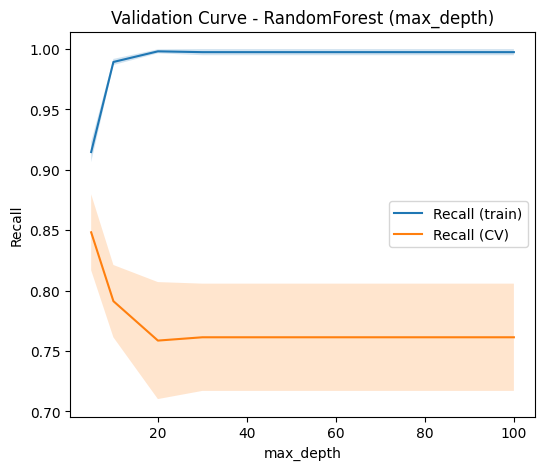

In [8]:
param_range = [5, 10, 20, 30, 40, 60, 80, 100]

train_scores, val_scores = validation_curve(
    estimator=baseline_RF,
    X=X_train, y=y_train,
    param_name="randomforestclassifier__max_depth",
    param_range=param_range,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

# Moyennes et écarts-types
train_mean = np.mean(train_scores, axis=1)
val_mean   = np.mean(val_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
val_std    = np.std(val_scores, axis=1)

# Plot
plt.figure(figsize=(6,5))
plt.plot(param_range, train_mean, label="Recall (train)")
plt.plot(param_range, val_mean, label="Recall (CV)")
plt.fill_between(param_range, train_mean-train_std, train_mean+train_std, alpha=0.2)
plt.fill_between(param_range, val_mean-val_std, val_mean+val_std, alpha=0.2)
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.title("Validation Curve - RandomForest (max_depth)")
plt.legend()
plt.savefig("../images/validation_curve_rf.png", dpi=300, bbox_inches="tight")
plt.show()

- **Recall (train)** increases strongly with `max_depth`, but always remains higher than Recall in CV → classic sign of **overfitting**.  
- **Recall (CV)** reaches its maximum at intermediate depths (`max_depth ≈ 10–20`) then stagnates or slightly decreases.  
- Beyond `max_depth=30`, the train–CV gap widens → no gain on validation data.  

For the next steps, we retain that **very large depths bring no benefit** and encourage overfitting.  
We let RandomizedSearchCV explore the space, but we expect good results for `max_depth` around **10–30**.


In [15]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_distributions = {
    "randomforestclassifier__n_estimators": randint(200, 500),
    "randomforestclassifier__max_depth": randint(10, 31),
    "randomforestclassifier__min_samples_leaf": randint(2, 6),
    "randomforestclassifier__max_features": ["sqrt", "log2"],
    "randomforestclassifier__max_samples": [0.5, 0.75, None]
}

rnd_fast = RandomizedSearchCV(
    estimator=baseline_RF,
    param_distributions=param_distributions,
    n_iter=10,
    scoring="roc_auc",
    refit=True,
    cv=cv,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=2
)
rnd_fast.fit(X_train, y_train)
print("Best params:", rnd_fast.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best params: {'randomforestclassifier__max_depth': 14, 'randomforestclassifier__max_features': 'sqrt', 'randomforestclassifier__max_samples': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__n_estimators': 366}


#### Tuned Random Forest - Evaluation

- Using the best RF model.
- Probabilities converted to predictions with a 0.5 threshold.
- Metrics computed: **ROC-AUC, PR-AUC, Recall, Precision, F1**.
- Results compared side by side with Logistic Regression.


In [16]:
rf_best = rnd_fast.best_estimator_

y_proba_rf = rf_best.predict_proba(X_test)[:, 1]
y_pred_rf  = (y_proba_rf >= 0.5).astype(int)


def eval_cls(y_true, y_pred, y_proba):
    return {
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "PR-AUC": average_precision_score(y_true, y_proba),
        "Recall": recall_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred),
    }

lr_results = eval_cls(y_test, y_pred_LR, y_proba)
rf_results = eval_cls(y_test, y_pred_rf, y_proba_rf)

compare_df = pd.DataFrame(
    [lr_results, rf_results],
    index=["Logistic Regression", "Random Forest (tuned)"]
).round(4)

compare_df

,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.9724,0.6929,0.8862,0.0637,0.1188
Random Forest (tuned),0.9738,0.8321,0.7724,0.9048,0.8333


- **Logistic Regression** achieves slightly higher **Recall** (better at catching frauds), but at the cost of very low Precision.  
- **Random Forest** provides a much better balance with very high **Precision** and a strong **F1-score**, while keeping ROC-AUC close to Logistic Regression.  
- Overall, **Random Forest is the stronger model** here, as it captures frauds with far fewer false positives.

Next, I will try the model **XGBoost** to check if it performs even better which, in theory, it should.

---

## XGBoost

To handle class imbalance (as fraud is a minority class), I split the training set into training and validation sets (≈15%). The validation set will be used for early stopping, not as a test set.

In [17]:
import xgboost as xgb
from xgboost import XGBClassifier

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE)

# I handle class imbalance (fraud = minority class)
pos = (y_train == 1).sum()
neg = (y_train == 0).sum()
scale_pos = neg / pos

I start with a simple Baseline model

In [41]:
xgb_baseline = make_pipeline(
    preprocess,
    XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos,
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
)

xgb_baseline.fit(X_tr, y_tr)

y_proba_xgb = xgb_baseline.predict_proba(X_test)[:, 1]
y_pred_xgb  = (y_proba_xgb >= 0.5).astype(int)

xgb_results = eval_cls(y_test, y_pred_xgb, y_proba_xgb)

if "XGBoost (baseline)" in compare_df.index:
    compare_df = compare_df.drop("XGBoost (baseline)")

compare_df.loc["XGBoost (baseline)", compare_df.columns] = \
    pd.Series(xgb_results)[compare_df.columns].values

compare_df


,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.972400,0.692900,0.886200,0.063700,0.118800
Random Forest (tuned),0.973800,0.832100,0.772400,0.904800,0.833300
XGBoost (baseline),0.983136,0.860783,0.837398,0.830645,0.834008


- **Logistic Regression** : slightly higher Recall, but at the cost of very low Precision.  
- **Random Forest** : strong balance, higher Precision and F1 compared to Logistic Regression.  
- **XGBoost** : outperforms both in overall trade-off, with solid PR-AUC and Recall.  
- This confirms that **XGBoost is the best model so far** for fraud detection on this dataset.  

Next step: perform a quick **hyperparameter tuning** on XGBoost to check if we can push performance further.

In [42]:
xgb_pipe = make_pipeline(
    preprocess,
    XGBClassifier(
        objective="binary:logistic",
        eval_metric="aucpr",
        tree_method="hist",
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=scale_pos
    )
)

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

param_dist = {
    "xgbclassifier__n_estimators": randint(400, 1601),
    "xgbclassifier__max_depth": randint(3, 10),
    "xgbclassifier__min_child_weight": randint(1, 11),
    "xgbclassifier__learning_rate": uniform(0.02, 0.18),
    "xgbclassifier__subsample": uniform(0.6, 0.4),
    "xgbclassifier__colsample_bytree": uniform(0.6, 0.4),
    "xgbclassifier__gamma": uniform(0.0, 5.0),
    "xgbclassifier__reg_lambda": uniform(0.0, 10.0)
}

rnd = RandomizedSearchCV(
    estimator=xgb_pipe,
    param_distributions=param_dist,
    n_iter=40,
    scoring="average_precision", # PR-AUC
    cv=cv,
    refit=True,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    verbose=1
)

rnd.fit(X_train, y_train)
print("Best (randomized) params:\n", rnd.best_params_)
print("Best CV PR-AUC:", rnd.best_score_)
best_rnd = rnd.best_estimator_

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best (randomized) params:
 {'xgbclassifier__colsample_bytree': 0.8010716092915446, 'xgbclassifier__gamma': 0.25739375624994676, 'xgbclassifier__learning_rate': 0.07015636356259006, 'xgbclassifier__max_depth': 3, 'xgbclassifier__min_child_weight': 1, 'xgbclassifier__n_estimators': 1553, 'xgbclassifier__reg_lambda': 5.309345833171363, 'xgbclassifier__subsample': 0.7791132658292367}
Best CV PR-AUC: 0.8531788619904624


After the wide exploration with RandomizedSearchCV, we now run a more **focused GridSearchCV**.  
The grid is built around the best parameters found previously, exploring only small variations.  
The goal is to refine the model hyperparameters and squeeze the last performance gains.

In [44]:
best = rnd.best_params_

grid_params = {
    "xgbclassifier__max_depth":        [2, 3, 4],
    "xgbclassifier__min_child_weight": [1, 2],
    "xgbclassifier__learning_rate":    [0.05, 0.07, 0.09],
    "xgbclassifier__subsample":        [0.7, 0.8, 0.9],
    # I fix the other values found by RandomizedSearchCV
    "xgbclassifier__colsample_bytree": [best["xgbclassifier__colsample_bytree"]],
    "xgbclassifier__gamma":            [best["xgbclassifier__gamma"]],
    "xgbclassifier__reg_lambda":       [best["xgbclassifier__reg_lambda"]],
    "xgbclassifier__n_estimators":     [best["xgbclassifier__n_estimators"]],
}

grid = GridSearchCV(
    estimator=rnd.best_estimator_,
    param_grid=grid_params,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    refit=True,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)
print("Best (grid) params:\n", grid.best_params_)
print("Best CV PR-AUC:", grid.best_score_)

y_proba_xgb_grid = grid.best_estimator_.predict_proba(X_test)[:, 1]
y_pred_xgb_grid  = (y_proba_xgb_grid >= 0.5).astype(int)
xgb_grid_results = eval_cls(y_test, y_pred_xgb_grid, y_proba_xgb_grid)

compare_df.loc["XGBoost (grid)", compare_df.columns] = \
    pd.Series(xgb_grid_results)[compare_df.columns].values
compare_df = compare_df.round(4)

compare_df

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Best (grid) params:
 {'xgbclassifier__colsample_bytree': 0.8010716092915446, 'xgbclassifier__gamma': 0.25739375624994676, 'xgbclassifier__learning_rate': 0.05, 'xgbclassifier__max_depth': 4, 'xgbclassifier__min_child_weight': 2, 'xgbclassifier__n_estimators': 1553, 'xgbclassifier__reg_lambda': 5.309345833171363, 'xgbclassifier__subsample': 0.9}
Best CV PR-AUC: 0.8559424940789025


,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.9724,0.6929,0.8862,0.0637,0.1188
Random Forest (tuned),0.9738,0.8321,0.7724,0.9048,0.8333
XGBoost (baseline),0.9831,0.8608,0.8374,0.8306,0.8340
XGBoost (grid),0.9837,0.8623,0.8049,0.8684,0.8354


After RandomizedSearchCV and GridSearchCV, we retrain XGBoost one last time:

- We split the training set into **train + validation**.
- The model is refit with a **high number of trees (2000)**.
- We use **early stopping**: training stops automatically if there is no improvement
  on the validation set for 50 rounds.
- This ensures the model uses the **optimal number of trees** and avoids overfitting.

The final model is then evaluated on the test set with the tuned threshold,
giving us the best balance between Precision and Recall.

In [51]:
from sklearn.base import clone

# Split training data for Early Stopping
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=RANDOM_STATE
)

# Preprocess
prep = clone(preprocess).fit(X_tr, y_tr)
X_tr_p, X_val_p = prep.transform(X_tr), prep.transform(X_val)

# Clone best model from GridSearch
xgb_final = clone(grid.best_estimator_.named_steps["xgbclassifier"])
xgb_final.set_params(
    n_estimators=2000,
    early_stopping_rounds=50,
    verbosity=0,
    eval_metric="aucpr"
)

# Fit with early stopping
xgb_final.fit(
    X_tr_p, y_tr,
    eval_set=[(X_val_p, y_val)],
    verbose=False
)

print("Best iteration:", xgb_final.best_iteration)
print("Best validation aucpr:", xgb_final.best_score)

final_model = make_pipeline(prep, xgb_final)

# Find optimal threshold on validation
y_val_proba = xgb_final.predict_proba(X_val_p)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)
f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

best_idx = f1_scores.argmax()
best_threshold = thresholds[best_idx]

print(f"Best threshold: {best_threshold:.3f}")
print(f"Precision: {precisions[best_idx]:.3f}")
print(f"Recall : {recalls[best_idx]:.3f}")
print(f"F1 : {f1_scores[best_idx]:.3f}")


# Evaluate final model on test set
y_proba_final = final_model.predict_proba(X_test)[:, 1]
y_pred_final  = (y_proba_final >= best_threshold).astype(int)

xgb_final_results = eval_cls(y_test, y_pred_final, y_proba_final)

compare_df.loc["XGBoost (Final)"] = \
    pd.Series(xgb_final_results)[compare_df.columns].values
compare_df = compare_df.round(4)

compare_df

Best iteration: 954
Best validation aucpr: 0.8396965763773818
Best threshold: 0.855
Precision: 0.967
Recall : 0.797
F1 : 0.874


,ROC-AUC,PR-AUC,Recall,Precision,F1
Logistic Regression,0.9724,0.6929,0.8862,0.0637,0.1188
Random Forest (tuned),0.9738,0.8321,0.7724,0.9048,0.8333
XGBoost (baseline),0.9831,0.8608,0.8374,0.8306,0.8340
XGBoost (grid),0.9837,0.8623,0.8049,0.8684,0.8354
XGBoost (Final),0.9833,0.8574,0.7967,0.9333,0.8596


### Final Results - Model Comparison

- **Logistic Regression**: high Recall but extremely poor Precision, not usable in practice.  
- **Random Forest (tuned)**: strong balance, Precision and F1 much higher than Logistic Regression.  
- **XGBoost (baseline)**: already very solid, outperforming Random Forest.  
- **XGBoost (grid)**: slight improvement from the baseline, thanks to fine-tuned hyperparameters.  
- **XGBoost (Final)**: best model overall, with a tuned threshold that delivers:
  - Precision ≈ 0.93  
  - F1 ≈ 0.86  
  - Excellent trade-off between catching frauds (Recall) and avoiding false alarms (Precision).  

This confirms that **XGBoost with tuned hyperparameters, early stopping, and an optimized threshold is the best model for fraud detection** on this dataset.

---


In [56]:
import joblib

joblib.dump(final_model, "../models/xgb_final_model.pkl")

['../models/xgb_final_model.pkl']

We save the full pipeline (`preprocess + XGBoost Final`) using **joblib**.  
This allows us to reload the trained model later without retraining, and use it directly for predictions.  

The model is saved in the `models/` folder as `xgb_final_model.pkl`.